In [81]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import progressbar
import time
import math

from elasticsearch import Elasticsearch
from pandas.io.json import json_normalize
from pprint import pprint

def to_date(s):
    dt = datetime.datetime.fromtimestamp(s / 1e3)
    return dt.strftime("%Y-%m-%d")

In [82]:
dsl_id = {
        'aggs': {'my_buckets': {'aggregations': {'打开(Visitor)': {'cardinality': {'field': 'session_id',
                                                                          'precision_threshold': 100}}},
                         'composite': {'size': 9999999,
                                       'sources': [
                                           {'日期': {'date_histogram': {'field': 'created',
                                                                              'interval': '1d',
                                                                              'time_zone': '+08:00'}}},
                                                   {'shop_group_id': {'terms': {'field': 'shop_group_id'}}}]}}},
         'query': {'bool': {'must': [{'range': {'created': {'format': 'yyyy-MM-dd',
                                                    'gte': '2019-01-01',
                                                    'lte': '2019-06-05',
                                                    'time_zone': '+08:00'}}},
                             {'terms': {'app_name': ['vip-mini']}},
                             {'terms': {'event_name': ['查看大图']}},
                            # {'terms':{"extra_source_keyword": ["商家菜单"] }},
                             {'terms': {'event_type': ['event']}}]}}}

    
es_id = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
res_id = es_id.search(index='shop_pv_event', doc_type='pv_event', body=dsl_id,
                _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                search_type='query_then_fetch')
df_id = json_normalize(res_id['aggregations']['my_buckets']['buckets'])
df_id.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df_id.columns))
df_id['日期'] = df_id['日期'].apply(to_date)
df_id['日期'] = pd.to_datetime(df_id['日期'])
del df_id['shop_group_id']
df_id=df_id.drop([0]).reset_index()
df_id.head()

,index,doc_count,日期,打开(Visitor).value
0,1,3961,2019-05-18,1507
1,2,6434,2019-05-19,2370
2,3,12709,2019-05-20,2683
3,4,7949,2019-05-21,2723
4,5,11135,2019-05-22,2871


In [83]:
dsl = {
        'aggs': {'my_buckets': {'aggregations': {'打开(Visitor)': {'cardinality': {'field': 'session_id',
                                                                          'precision_threshold': 100}}},
                         'composite': {'size': 9999999,
                                       'sources': [
                                           {'日期': {'date_histogram': {'field': 'created',
                                                                              'interval': '1d',
                                                                              'time_zone': '+08:00'}}},
                                                   {'shop_group_id': {'terms': {'field': 'shop_group_id'}}}]}}},
         'query': {'bool': {'must': [{'range': {'created': {'format': 'yyyy-MM-dd',
                                                    'gte': '2019-01-01',
                                                    'lte': '2019-06-05',
                                                    'time_zone': '+08:00'}}},
                             {'terms': {'app_name': ['vip-mini']}},
                             {'terms': {'event_name': ['查看大图']}},
                             {'terms':{"extra.source.keyword": ["商家菜单"]}},
                             {'terms': {'event_type': ['event']}}]}}}

    
es = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
res = es_id.search(index='shop_pv_event', doc_type='pv_event', body=dsl,
                _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                search_type='query_then_fetch')
df = json_normalize(res['aggregations']['my_buckets']['buckets'])
df.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df.columns))
df['日期'] = df['日期'].apply(to_date)
df['日期'] = pd.to_datetime(df['日期'])
del df['shop_group_id']
df.head()

,doc_count,日期,打开(Visitor).value
0,3137,2019-05-18,1313
1,5214,2019-05-19,2092
2,5675,2019-05-20,2180
3,6439,2019-05-21,2421
4,6692,2019-05-22,2440


In [84]:
df['all']=df_id['打开(Visitor).value']

In [79]:
#df=df.drop([len(df)-1])

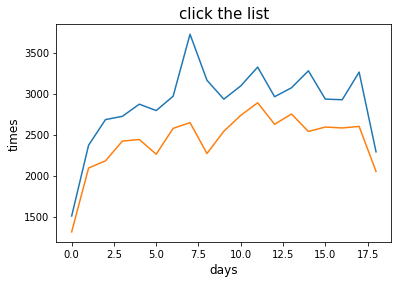

In [86]:
plt.plot(df['all'])
plt.plot(df['打开(Visitor).value'])
plt.title("click the list",fontsize=15)
plt.xlabel("days",fontsize=12)
plt.ylabel("times",fontsize=12)
plt.show()

In [69]:
sum(df['打开(Visitor).value'])/sum(df['all'])

0.8389185002120949